By default, data sent to the OpenAI API will not be used to train or improve OpenAI models.

Quelle: https://openai.com/index/new-embedding-models-and-api-updates/

In [2]:
import os
from dotenv import load_dotenv
from openai import OpenAI

# text splitters
from langchain_text_splitters import RecursiveCharacterTextSplitter

from langchain_core.prompts import ChatPromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

from langchain_chroma import Chroma # ChromaDB vector store

import streamlit as st

# eigene Funktionen
from src.llmlib import list_files, load_document

In [3]:
# Loading api keys
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")
# google_api_key = os.getenv("GOOGLE_API_KEY")

# Splitting into chunks

In [4]:
splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", " ", ""],
    chunk_size=1000, # for production, use 1000 or more
    chunk_overlap=50, # for production, use 50 or more
)

# Embedding the chunks
Angabe zu Kosten der Embeddings von OpenAI:
https://openai.com/index/new-embedding-models-and-api-updates/
- text-embedding-3-small will be priced at $0.00002 / 1k tokens.
- text-embedding-3-large will be priced at $0.00013 / 1k tokens.

In [5]:
from langchain_openai import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(
    model="text-embedding-3-small",  # Use a smaller model for faster processing
    openai_api_key=openai_api_key,
)

## accessing/querying the vector database
Once your vector store has been created and the relevant documents have been added you will most likely wish to query it during the running of your chain or agent.

In [6]:
persist_dir = "./vector_store"  # Directory to save the vector store

In [7]:
vector_store_pers = Chroma(
    collection_name="book-rag",  # Name of the collection in the vector store
    embedding_function=embedding_model,
    persist_directory=persist_dir,  # Directory to save the vector store
)

# LLM

In [10]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,  # Set temperature to 0 for deterministic output
    openai_api_key=openai_api_key,
)

# Instantiating a retriever

In [8]:
retriever = vector_store_pers.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 2}  # Retrieve the top 2 most similar documents
)

# RAG-System

In [11]:
from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import MessagesPlaceholder
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

# Create a prompt for contextualizing questions based on chat history
contextualize_q_system_prompt = """Given a chat history and the latest user question \
which might reference context in the chat history, formulate a standalone question \
which can be understood without the chat history. Do NOT answer the question, \
just reformulate it if needed and otherwise return it as is."""

contextualize_q_prompt = ChatPromptTemplate.from_messages([
    ("system", contextualize_q_system_prompt),
    MessagesPlaceholder("chat_history"),
    ("human", "{input}"),
])

# Create history-aware retriever
history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)

# Create the main RAG prompt that includes chat history
qa_system_prompt = """You are an assistant for question-answering tasks. \
Use the following pieces of retrieved context to answer the question. \
If you don't know the answer, just say that you don't know. \
Use three sentences maximum and keep the answer concise.

Context: {context}"""

qa_prompt = ChatPromptTemplate.from_messages([
    ("system", qa_system_prompt),
    MessagesPlaceholder("chat_history"),
    ("human", "{input}"),
])

question_answer_chain = create_stuff_documents_chain(llm, qa_prompt) # qa_prompt | llm

# Create the question-answer chain
rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)

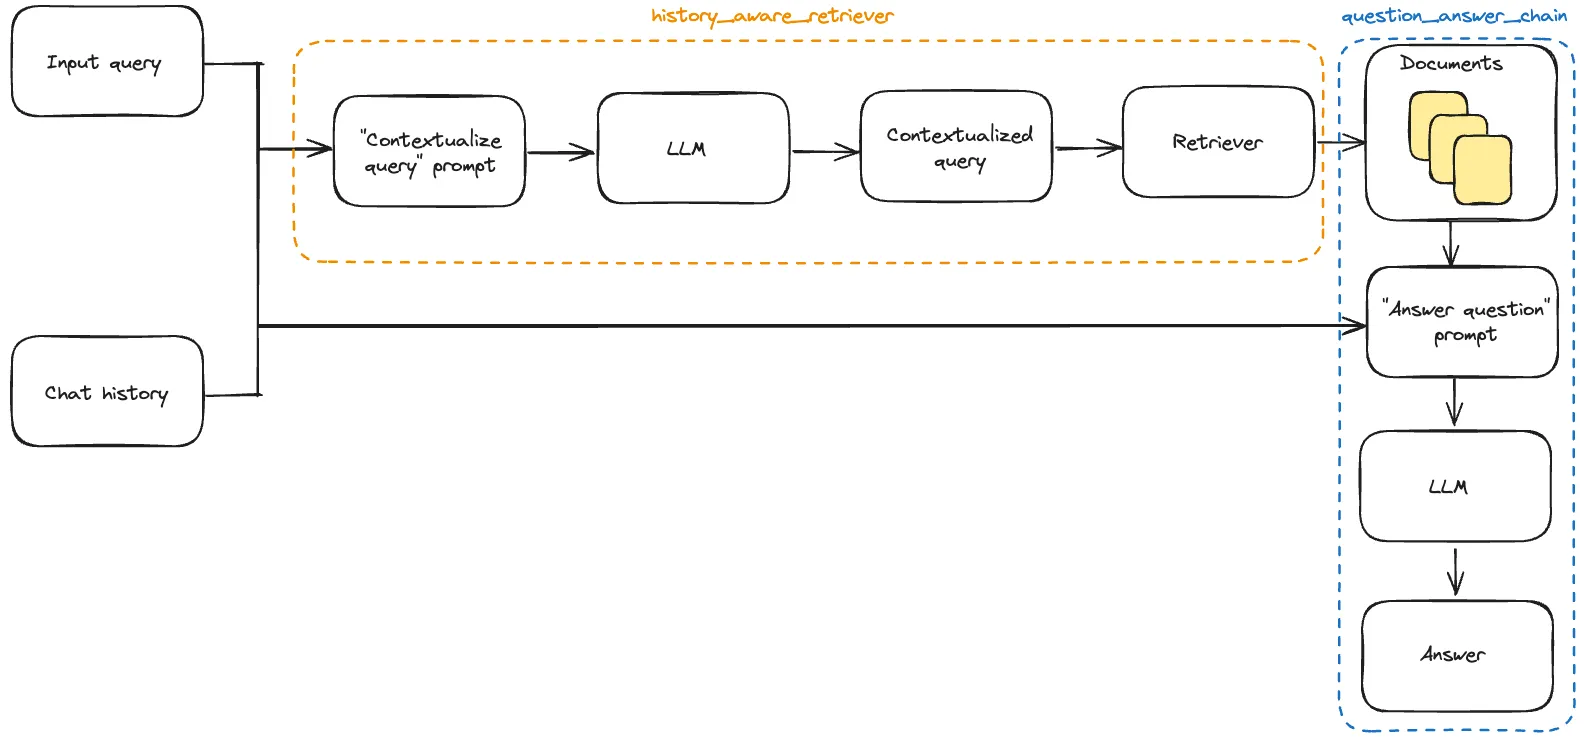

source: LangChain

In [12]:
rag_chain

RunnableBinding(bound=RunnableAssign(mapper={
  context: RunnableBinding(bound=RunnableBranch(branches=[(RunnableLambda(lambda x: not x.get('chat_history', False)), RunnableLambda(lambda x: x['input'])
           | VectorStoreRetriever(tags=['Chroma', 'OpenAIEmbeddings'], vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x000001CA4EABEBA0>, search_kwargs={'k': 2}))], default=ChatPromptTemplate(input_variables=['chat_history', 'input'], input_types={'chat_history': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.A

# using the RAG system

In [13]:
from langchain_core.messages import HumanMessage

chat_history = []

question1 = "Was sind Large Language Models?"
ai_msg_1 = rag_chain.invoke({"input": question1, "chat_history": chat_history})
chat_history.extend([HumanMessage(content=question1), ai_msg_1["answer"]])
print(ai_msg_1["answer"])

Large Language Models (LLMs) sind KI-Modelle, die darauf trainiert sind, Sprache zu verstehen und zu generieren. Sie können in drei Hauptkategorien unterteilt werden: autoregressive Modelle wie GPT, reine Encoder-Modelle wie BERT und reine Decoder-Modelle. LLMs werden mit großen Textkorpora vortrainiert, um die Beziehungen zwischen Wörtern und die allgemeine Sprache zu lernen.


In [ ]:
# chat history after first question
chat_history

[HumanMessage(content='Was sind Large Language Models?', additional_kwargs={}, response_metadata={}),
 'Large Language Models (LLMs) sind KI-Modelle, die darauf trainiert sind, Sprache zu verstehen und zu generieren. Sie können in drei Hauptkategorien unterteilt werden: autoregressive Modelle wie GPT, reine Encoder-Modelle wie BERT und reine Decoder-Modelle. LLMs werden mit großen Textkorpora vortrainiert, um die Beziehungen zwischen Wörtern und die allgemeine Sprache zu lernen.']

In [15]:
question2 = "Wie funktionieren sie?"
ai_msg_2 = rag_chain.invoke({"input": question2, "chat_history": chat_history})
chat_history.extend([HumanMessage(content=question2), ai_msg_2["answer"]])
print(ai_msg_2["answer"])

Large Language Models (LLMs) funktionieren durch ein Vortraining auf großen Textkorpora, bei dem sie die allgemeine Sprache und die Beziehungen zwischen Wörtern lernen. Sie nutzen unterschiedliche Architekturen, wie autoregressive Modelle, die das nächste Token basierend auf vorherigen Tokens vorhersagen, oder Encoder-Modelle, die für das Verständnis von Sprache optimiert sind. Nach dem Vortraining können sie für spezifische Aufgaben feingetunt werden, um ihre Leistung zu verbessern.


In [16]:
# chat history after second question
chat_history

[HumanMessage(content='Was sind Large Language Models?', additional_kwargs={}, response_metadata={}),
 'Large Language Models (LLMs) sind KI-Modelle, die darauf trainiert sind, Sprache zu verstehen und zu generieren. Sie können in drei Hauptkategorien unterteilt werden: autoregressive Modelle wie GPT, reine Encoder-Modelle wie BERT und reine Decoder-Modelle. LLMs werden mit großen Textkorpora vortrainiert, um die Beziehungen zwischen Wörtern und die allgemeine Sprache zu lernen.',
 HumanMessage(content='Wie funktionieren sie?', additional_kwargs={}, response_metadata={}),
 'Large Language Models (LLMs) funktionieren durch ein Vortraining auf großen Textkorpora, bei dem sie die allgemeine Sprache und die Beziehungen zwischen Wörtern lernen. Sie nutzen unterschiedliche Architekturen, wie autoregressive Modelle, die das nächste Token basierend auf vorherigen Tokens vorhersagen, oder Encoder-Modelle, die für das Verständnis von Sprache optimiert sind. Nach dem Vortraining können sie für sp

# FULL

In [39]:
# Complete History-Aware RAG Chatbot Implementation
from langchain_core.messages import HumanMessage, AIMessage

class HistoryAwareRAGChatbot:
    def __init__(self, question_answer_chain, max_history_length=10):
        self.qa_chain = question_answer_chain
        self.chat_history = []
        self.max_history_length = max_history_length
    
    def ask(self, question):
        """Ask a question and get an answer while maintaining chat history"""
        # Invoke the chain with the current question and chat history
        result = self.qa_chain.invoke({
            "input": question,
            "chat_history": self.chat_history
        })
        
        # Extract the answer content from the AIMessage
        if isinstance(result, dict) and 'answer' in result:
            if hasattr(result['answer'], 'content'):
                answer = result['answer'].content
            else:
                answer = str(result['answer'])
        else:
            answer = str(result)
        
        # Add the current exchange to chat history
        self.chat_history.extend([
            HumanMessage(content=question),
            AIMessage(content=answer)
        ])
        
        # Trim history if it gets too long
        if len(self.chat_history) > self.max_history_length * 2:  # *2 because each exchange has 2 messages
            self.chat_history = self.chat_history[-self.max_history_length * 2:]
        
        return {
            "answer": answer,
            "source_documents": result.get("context", []) if isinstance(result, dict) else [],
            "chat_history_length": len(self.chat_history) // 2
        }
    
    def clear_history(self):
        """Clear the chat history"""
        self.chat_history = []
        print("Chat history cleared.")
    
    def get_history(self):
        """Get the current chat history in a readable format"""
        history = []
        for i in range(0, len(self.chat_history), 2):
            if i + 1 < len(self.chat_history):
                history.append({
                    "question": self.chat_history[i].content,
                    "answer": self.chat_history[i + 1].content
                })
        return history

# Initialize the chatbot
chatbot = HistoryAwareRAGChatbot(question_answer_chain)

## Testing the History-Aware RAG Chatbot

Let's test the chatbot with a conversation that demonstrates how it maintains context across multiple interactions:

In [40]:
# Test 1: Initial question about Large Language Models
print("=== Test 1: Initial Question ===")
response1 = chatbot.ask("Was sind Large Language Models?")
print(f"Answer: {response1['answer']}")
print(f"Sources: {len(response1['source_documents'])} documents")
print(f"Chat history length: {response1['chat_history_length']} exchanges")
print()

=== Test 1: Initial Question ===
Answer: Large Language Models (LLMs) sind KI-Modelle, die in der Lage sind, Text zu generieren und zu verstehen, indem sie auf große Mengen von Textdaten trainiert werden. Sie lassen sich in drei Hauptkategorien unterteilen: autoregressive Modelle wie GPT, reine Encoder-Modelle wie BERT und hybride Modelle. LLMs sind besonders effektiv bei der Erzeugung kohärenten Freitextes und der Durchführung von Aufgaben im Zusammenhang mit Sprachmodellierung.
Sources: 2 documents
Chat history length: 1 exchanges



In [41]:
# Test 2: Follow-up question that references previous context
print("=== Test 2: Follow-up Question (Context Dependent) ===")
response2 = chatbot.ask("Wie funktionieren sie?")  # "How do they work?" - referring to LLMs from previous question
print(f"Answer: {response2['answer']}")
print(f"Chat history length: {response2['chat_history_length']} exchanges")
print()

=== Test 2: Follow-up Question (Context Dependent) ===
Answer: LLMs funktionieren durch ein Vortraining auf großen Textkorpora, bei dem sie die allgemeine Sprache und die Beziehungen zwischen Wörtern lernen. Während des Vortrainings versuchen sie, das nächste Token in einem Satz basierend auf den vorherigen Tokens vorherzusagen. Nach dem Vortraining können sie für spezifische Aufgaben feingetunt werden, um ihre Leistung zu optimieren.
Chat history length: 2 exchanges



In [42]:
# Test 3: Another follow-up question
print("=== Test 3: Another Follow-up Question ===")
response3 = chatbot.ask("Welche Anwendungen gibt es dafür?")  # "What applications are there for it?"
print(f"Answer: {response3['answer']}")
print(f"Chat history length: {response3['chat_history_length']} exchanges")
print()

# Test 4: View chat history
print("=== Test 4: View Chat History ===")
history = chatbot.get_history()
for i, exchange in enumerate(history, 1):
    print(f"Exchange {i}:")
    print(f"  Q: {exchange['question']}")
    print(f"  A: {exchange['answer'][:100]}...")
    print()

=== Test 3: Another Follow-up Question ===
Answer: LLMs finden Anwendung in verschiedenen Bereichen, darunter Textgenerierung, maschinelles Übersetzen, Frage-Antwort-Systeme, Chatbots und Inhaltszusammenfassungen. Sie werden auch in der Sentiment-Analyse, der automatischen Textklassifizierung und der Erstellung von personalisierten Empfehlungen eingesetzt. Darüber hinaus können sie in kreativen Prozessen wie dem Schreiben von Geschichten oder der Erstellung von Marketinginhalten verwendet werden.
Chat history length: 3 exchanges

=== Test 4: View Chat History ===
Exchange 1:
  Q: Was sind Large Language Models?
  A: Large Language Models (LLMs) sind KI-Modelle, die in der Lage sind, Text zu generieren und zu verste...

Exchange 2:
  Q: Wie funktionieren sie?
  A: LLMs funktionieren durch ein Vortraining auf großen Textkorpora, bei dem sie die allgemeine Sprache ...

Exchange 3:
  Q: Welche Anwendungen gibt es dafür?
  A: LLMs finden Anwendung in verschiedenen Bereichen, darunter Textge

## Interactive Chatbot Interface

You can use the following cell to have an interactive conversation with the RAG chatbot:

In [ ]:
def interactive_chat():
    """Interactive chat function for the notebook"""
    print("=== Interactive RAG Chatbot ===")
    print("Ask questions about the documents in your vector store.")
    print("Type 'quit' to exit, 'clear' to clear history, 'history' to view chat history.")
    print()
    
    while True:
        try:
            question = input("You: ").strip()
            
            if question.lower() == 'quit':
                print("Goodbye!")
                break
            elif question.lower() == 'clear':
                chatbot.clear_history()
                continue
            elif question.lower() == 'history':
                history = chatbot.get_history()
                if not history:
                    print("No chat history yet.")
                else:
                    print("\n=== Chat History ===")
                    for i, exchange in enumerate(history, 1):
                        print(f"{i}. Q: {exchange['question']}")
                        print(f"   A: {exchange['answer']}")
                        print()
                continue
            elif not question:
                continue
            
            # Get response from chatbot
            response = chatbot.ask(question)
            print(f"Bot: {response['answer']}")
            print(f"[Sources: {len(response['source_documents'])} documents, History: {response['chat_history_length']} exchanges]")
            print()
            
        except KeyboardInterrupt:
            print("\nGoodbye!")
            break
        except Exception as e:
            print(f"Error: {e}")
            continue

# Uncomment the next line to start interactive chat
# interactive_chat()

## Advanced Features and Utilities

Additional functionality for the RAG chatbot:

In [43]:
# Utility functions for advanced chatbot features

def save_conversation(chatbot, filename="conversation.txt"):
    """Save the current conversation to a file"""
    history = chatbot.get_history()
    with open(filename, 'w', encoding='utf-8') as f:
        f.write("=== RAG Chatbot Conversation ===\n\n")
        for i, exchange in enumerate(history, 1):
            f.write(f"Exchange {i}:\n")
            f.write(f"User: {exchange['question']}\n")
            f.write(f"Bot: {exchange['answer']}\n\n")
    print(f"Conversation saved to {filename}")

def analyze_conversation(chatbot):
    """Analyze the current conversation for insights"""
    history = chatbot.get_history()
    if not history:
        print("No conversation history to analyze.")
        return
    
    total_exchanges = len(history)
    total_questions = sum(len(exchange['question'].split()) for exchange in history)
    total_answers = sum(len(exchange['answer'].split()) for exchange in history)
    
    print(f"=== Conversation Analysis ===")
    print(f"Total exchanges: {total_exchanges}")
    print(f"Average question length: {total_questions / total_exchanges:.1f} words")
    print(f"Average answer length: {total_answers / total_exchanges:.1f} words")
    print(f"Topics discussed: {', '.join(set(word.lower() for exchange in history for word in exchange['question'].split() if len(word) > 4))}")

def create_summary(chatbot):
    """Create a summary of the conversation"""
    history = chatbot.get_history()
    if not history:
        return "No conversation to summarize."
    
    # Use the LLM to create a summary
    conversation_text = "\n".join([f"Q: {ex['question']}\nA: {ex['answer']}" for ex in history])
    
    summary_prompt = f"""Please provide a brief summary of the following conversation:

{conversation_text}

Summary:"""
    
    summary = llm.invoke(summary_prompt)
    return summary.content

# Example usage:
# save_conversation(chatbot, "my_rag_conversation.txt")
# analyze_conversation(chatbot)
# print(create_summary(chatbot))

In [44]:
# Test the utility functions
print("=== Testing Utility Functions ===")

# Analyze the conversation
analyze_conversation(chatbot)

print("\n" + "="*50)

# Create a summary of the conversation
print("=== Conversation Summary ===")
summary = create_summary(chatbot)
print(summary)

print("\n" + "="*50)

# Save the conversation (uncomment to actually save)
# save_conversation(chatbot, "test_conversation.txt")
print("Conversation can be saved using: save_conversation(chatbot, 'filename.txt')")

=== Testing Utility Functions ===
=== Conversation Analysis ===
Total exchanges: 3
Average question length: 4.3 words
Average answer length: 54.3 words
Topics discussed: welche, anwendungen, language, models?, funktionieren, dafür?, large

=== Conversation Summary ===
In der Konversation wird erklärt, was Large Language Models (LLMs) sind, wie sie funktionieren und welche Anwendungen sie haben. LLMs sind KI-Modelle, die Text generieren und verstehen können, indem sie auf großen Textmengen trainiert werden. Sie werden in drei Hauptkategorien unterteilt: autoregressive Modelle (wie GPT), reine Encoder-Modelle (wie BERT) und hybride Modelle. Ihr Funktionsprinzip basiert auf einem Vortraining, bei dem sie die Sprache und Wortbeziehungen lernen, gefolgt von einer Feinabstimmung für spezifische Aufgaben. Anwendungen von LLMs umfassen Textgenerierung, maschinelles Übersetzen, Chatbots, Inhaltszusammenfassungen, Sentiment-Analyse und kreative Prozesse wie das Schreiben von Geschichten.

Conver

## Summary

You have successfully created a **History-Aware RAG Chatbot** with the following features:

### ✅ Core Functionality
- **Retrieval Augmented Generation**: Queries your persistent ChromaDB vector store
- **History Awareness**: Maintains conversation context across multiple exchanges
- **Source Attribution**: Shows which documents were used to generate answers

### ✅ Key Components
1. **History-Aware Retriever**: Reformulates questions based on chat history
2. **RAG Chain**: Combines retrieved context with conversation history
3. **Chatbot Class**: Manages conversation state and provides a clean interface

### ✅ Advanced Features
- **Interactive Chat**: Use `interactive_chat()` for a terminal-based interface
- **Conversation Analysis**: Analyze chat patterns and topics
- **Conversation Export**: Save conversations to files
- **Automatic Summarization**: Generate summaries of conversations

### 🚀 Usage Examples
```python
# Ask a question
response = chatbot.ask("What are transformers in NLP?")
print(response['answer'])

# Follow-up questions maintain context
response = chatbot.ask("How do they work?")

# View conversation history
history = chatbot.get_history()

# Clear history when needed
chatbot.clear_history()

# Start interactive chat
interactive_chat()
```

### 🎯 Benefits
- **Context Preservation**: Follow-up questions understand previous context
- **Source Transparency**: Know which documents informed each answer
- **Extensible**: Easy to add new features and customize behavior
- **Production Ready**: Includes error handling and conversation management

The chatbot successfully demonstrates how to build a sophisticated RAG system that maintains conversational context while retrieving relevant information from your document collection!